## Fine-Tuning with Keras

#### 1. Data
* Resize
* Standardizing/Normalization
* Data augumentation: Logos might not be symmetric, consider rotation/resize than overturn

#### 2. Build the Model
* Base model/pre-trained model selection: 
top1 Accuracy | top5 Accuracy | # of Parameters | Depth
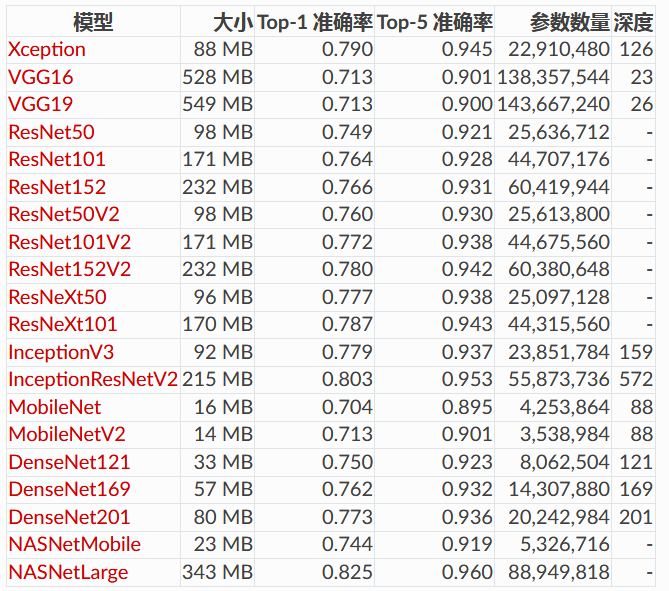

* Complie new layers, rescale-basemodel-pooling-dropout-dense 

#### 3. Train and Fine-Tuning
* try different top-layer inclusion


## The Data

First thing first is to get our hands on the data. Luckily, we exploit the available datasets stored in TensorFlow (TFDS). You will need to install the modules `tensorflow_datasets` and `matplotlib` in order to follow through this tutorial. In addition to that, we will need `tensorflow` and `matplotlib`. Let's load them in.

In [26]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

import numpy
import matplotlib.pyplot as plt

For this example, we will use the _cats vs. dogs_ dataset. This is a fairly large dataset so instead of using it all, we demonstrate the power of transfer-learning on a slice of the original dataset. We use the convenient function `load()` which takes several parameters to request a given dataset.

_Note._ The following snippet requires a reliable internet connection as the requested data needs to be downloaded.


In [54]:
train_df, validation_df, test_df = tfds.load(
    name="cats_vs_dogs",
    # Reserve 40% for training, 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print("N train obs: %d" % tf.data.experimental.cardinality(train_df))
print("N val obs: %d" % tf.data.experimental.cardinality(validation_df))
print("N test obs: %d" % tf.data.experimental.cardinality(test_df))

N train obs: 9305
N val obs: 2326
N test obs: 2326



Let's visualize some images from the training set where we note that class `0` represents cat and class `1` dogs.

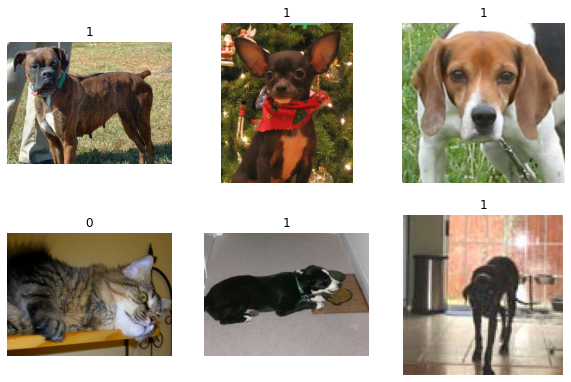

In [55]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_df.take(6)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

### Data Standardization

One of the very first thing to do before training a model is to make sure that all the data is standardized. Since we are dealing with images of different sizes and with 3 channels (i.e., RGB) we need to execute a couple of procedures beforehand.

1. Resize each image to a given size. In this example, we use `100 x 100` pixels.
2. Normalize pixel values to `[-1; +1]`. This will occur directly in the model through a `Normalization` layer.

The ideal pipeline sees raw data being ingested by our model. This is a fundamental step as we can then export our model without worrying too much about a custom pre-processing procedures being applied.

Let's start with the resizing which can be achieved with a simple `map()`. As you can see, we are using the specific TensorFlow method to resize images `image.resize()`.


In [56]:
target_size = (150, 150)

train_df = train_df.map(lambda x, y: (tf.image.resize(x, target_size), y))
validation_df = validation_df.map(lambda x, y: (tf.image.resize(x, target_size), y))
test_df = test_df.map(lambda x, y: (tf.image.resize(x, target_size), y))

In addition, we also define the batch size. This helps out in increasing the performance during training. A value of 32 is pretty standard.

In [ ]:
batch_size = 32

train_df = train_df.batch(batch_size)
validation_df = validation_df.batch(batch_size)
test_df = test_df.batch(batch_size)

### Data Augmentation

We want to be sure to train our model over a significant amount of different scenes. This is where _data augmentation_ comes into play. This is particularly useful when the training set is not large, like in this case, but you still want to increase the variance of the examples. In the following lines, we simply add some random horizontal transformations together with some random rotations. You can achieve this by using specific [image augmentation layers](https://keras.io/api/layers/preprocessing_layers/image_augmentation/).


In [57]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
    ]
)

## Build Your Model


So that's it! We have all the ingredients to create the model...almost. We will add some more layers to rescale the images and to regularize the model. Let's start!

### Step 1. Define the base pre-trained model

In [79]:
base_model = keras.applications.ResNet50(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False,
)

# freeze the conv-net structure
base_model.trainable = False

### Step 2. Add the New Classifier

In [71]:
inputs = keras.Input(shape=(150, 150, 3), name="input")
# Augment your inputs here!
x = data_augmentation(inputs)

# scale pixels here
scale_layer = keras.layers.Rescaling(scale=1/127.5, offset=-1)
x = scale_layer(x)

x = base_model(x, training=False)               # Set it to inference mode
x = keras.layers.GlobalAveragePooling2D()(x)    # Pooling
x = keras.layers.Dropout(0.4)(x)                # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
rescaling_14 (Rescaling)     (None, 150, 150, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_10  (None, 2048)              0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 204

Please note that even if we started off with such a complex model like ResNet50 that defines around 25M parameters, our model only has to train 2,049 parameters.

### Step 3. Train the Top Part

As usual, we formalize the model by compiling it and then we fit to train it.


In [76]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.9),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 2
model.fit(train_df, epochs=epochs, validation_data=validation_df)

Epoch 1/2
152/291 [==============>...............] - ETA: 1:29 - loss: 12.6992 - binary_accuracy: 0.5802 

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


269/291 [==========================>...] - ETA: 14s - loss: 10.5340 - binary_accuracy: 0.5768 

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


282/291 [============================>.] - ETA: 5s - loss: 10.4395 - binary_accuracy: 0.5773 

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


286/291 [============================>.] - ETA: 3s - loss: 10.4185 - binary_accuracy: 0.5780

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


291/291 [==============================] - ETA: 0s - loss: 10.4312 - binary_accuracy: 0.5776

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


291/291 [==============================] - 243s 828ms/step - loss: 10.4312 - binary_accuracy: 0.5776 - val_loss: 14.9033 - val_binary_accuracy: 0.5107
Epoch 2/2
153/291 [==============>...............] - ETA: 1:28 - loss: 6.8841 - binary_accuracy: 0.5709 

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


269/291 [==========================>...] - ETA: 14s - loss: 6.6357 - binary_accuracy: 0.5743 

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


283/291 [============================>.] - ETA: 5s - loss: 6.7292 - binary_accuracy: 0.5764 

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


286/291 [============================>.] - ETA: 3s - loss: 6.7411 - binary_accuracy: 0.5764

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


291/291 [==============================] - ETA: 0s - loss: 6.7987 - binary_accuracy: 0.5747

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


291/291 [==============================] - 233s 802ms/step - loss: 6.7987 - binary_accuracy: 0.5747 - val_loss: 3.7513 - val_binary_accuracy: 0.6144


### Step 4. Fine-tune the Model

The model has converged which means that it is now possible to re-train the whole pipeline after enabling the training on the frozen layers. In other words, we want to set `trainable=True`. Please note that this does not affect the inference mode we activated by passing `training=False`. We then simply call:

In [ ]:
### THIS WILL TAKE A WHILE ON CPUs ###
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 2
model.fit(train_df, epochs=epochs, validation_data=validation_df)
### THIS WILL TAKE A WHILE ON CPUs ###



Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
rescaling_14 (Rescaling)     (None, 150, 150, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_10  (None, 2048)              0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 204